In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import basic package and Setting basic functions

In [29]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
pi = np.pi
import time
from functools import wraps

In [30]:
def timer_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} Time Consuming: {end - start:.6f} s")
        return result

    return wrapper


@timer_decorator
def solve_coeff_Taylor():
    tra_a0_dict = {}
    for M in M_set:
        tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)
    return tra_a0_dict


@timer_decorator
def solve_coeff_Wang():
    wang_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_2D(v, h, tao, freq_max, L=20)
        wang_a0_dict["Wang" + f" M={M}"] = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),  # setting initial FD operator
            # alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            epsilon=1e-10,
            max_iter_num=max_iter_num,
            mode_of_construct="lstsq",
            solver=cholesky_solver,
            show_process=False,
        )
    return wang_a0_dict, linear_sys


@timer_decorator
def solve_coeff_QA():

    # Using the real Quantum Annealing Hardware Dwave System!
    # You should sign up a count and get your API.
    # sampler = DWaveSampler(
    #     token="YOUR API TOKEN",
    #     solver="Advantage_system6.4",
    #     region="na-west-1",
    # )  #

    # Using your computer to simulate the quantum annealing.
    sampler = SimulatedAnnealingSampler()  # for test

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_2D(v, h, tao, freq_max, L=20)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.ones(M) / 100,  # initial vector of Delta a
            num_sample=100,  # 5000
            R=10,
            fixed_point=1,
            maxiter=3,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
        )
        qa_a0 = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),
            epsilon=1e-10,
            alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
            show_process=False,
            # SampleSolver_param_dict={"drate":0.9}
        )
        qa_a0_dict[f"QA M={M}"] = qa_a0

    return qa_a0_dict

## set plot function

In [31]:
def show_disp_curve(result_dict):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

    lw = 1.1  # linwidth of box
    style_set = ["-", "--", ":"]
    linwith = 1.2
    counter = 0
    for label, coeff in result_dict.items():
        for str_theta, theta in zip(["0", "$\\pi/8$", "$\\pi/4$"], [0, pi / 8, pi / 4]):
            sigma = linear_sys.cal_sigma(
                v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff, theta=theta
            )
            if "Tra" in label:
                ax[0].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="maroon",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="Tra" + "  " + f"$\\theta=${str_theta}",
                )
            elif "QA" in label:
                ax[0].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="midnightblue",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="QA" + "  " + f"$\\theta=${str_theta}",
                )
            counter = (counter + 1) % 3
    ax[0].set_ylim([0.9, 1.05])
    ax[0].set_xlim([0, 3.142])
    ax[0].set_ylabel("$\delta(\\theta)$", fontsize=12)
    ax[0].set_xlabel("$kh$", fontsize=12)
    ax[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    ax[0].set_yticks([0.9, 0.95, 1.0, 1.05])
    # 设置边框粗细
    ax[0].spines["left"].set_linewidth(lw)
    ax[0].spines["top"].set_linewidth(lw)
    ax[0].spines["right"].set_linewidth(lw)
    ax[0].spines["bottom"].set_linewidth(lw)

    # 设置主刻度格式
    ax[0].tick_params(
        top=True,
        right=True,
        which="major",
        direction="in",
        length=4,
        width=1.0,
        colors="black",
        labelsize=8,
    )
    # 设置次刻度格式
    ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))  # 显示子刻度,括号里的是间距
    ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
    # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
    ax[0].tick_params(
        top=True,
        right=True,
        direction="in",
        which="minor",
        length=2,
        width=0.8,
        colors="black",
    )

    ax[0].grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)
    ax[0].legend(
        title="",
        fontsize="x-small",
        loc="lower left",
        borderpad=1.0,  # 图例内部留白
        borderaxespad=2.0,  # 图框边界距离坐标轴距离
        labelspacing=0.5,  # 图例条目间距
        edgecolor="black",
        handlelength=2.5,
    )
    ax[0].text(
        x=-0.5,
        y=1.055,
        s="(a)",
        fontfamily="Arial",
        fontsize=13,
        fontweight="bold",
    )


    counter = 0
    for label, coeff in result_dict.items():
        for str_theta, theta in zip(["0", "$\\pi/8$", "$\\pi/4$"], [0, pi / 8, pi / 4]):
            sigma = linear_sys.cal_sigma(
                v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff, theta=theta
            )
            if "Wang" in label:
                ax[1].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="maroon",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="Wang" + "  " + f"$\\theta=${str_theta}",
                )
            elif "QA" in label:
                ax[1].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="midnightblue",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="QA" + "  " + f"$\\theta=${str_theta}",
                )
            counter = (counter + 1) % 3
    ax[1].set_ylim([0.9, 1.05])
    ax[1].set_xlim([0, 3.142])
    ax[1].set_ylabel("$\delta(\\theta)$", fontsize=12)
    ax[1].set_xlabel("$kh$", fontsize=12)
    ax[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    ax[1].set_yticks([0.9, 0.95, 1.0, 1.05])
    # 设置边框粗细
    ax[1].spines["left"].set_linewidth(lw)
    ax[1].spines["top"].set_linewidth(lw)
    ax[1].spines["right"].set_linewidth(lw)
    ax[1].spines["bottom"].set_linewidth(lw)

    # 设置主刻度格式
    ax[1].tick_params(
        top=True,
        right=True,
        which="major",
        direction="in",
        length=4,
        width=1.0,
        colors="black",
        labelsize=8,
    )
    # 设置次刻度格式
    ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))  # 显示子刻度,括号里的是间距
    ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
    # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
    ax[1].tick_params(
        top=True,
        right=True,
        direction="in",
        which="minor",
        length=2,
        width=0.8,
        colors="black",
    )

    ax[1].grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)
    ax[1].legend(
        title="",
        fontsize="x-small",
        loc="lower left",
        borderpad=1.0,  # 图例内部留白
        borderaxespad=2.0,  # 图框边界距离坐标轴距离
        labelspacing=0.5,  # 图例条目间距
        edgecolor="black",
        handlelength=2.5,
    )

    ax[1].text(
        x=-0.5,
        y=1.055,
        s="(b)",
        fontfamily="Times New Roman",
        fontsize=13,
        fontweight="bold",
    )
    return fig, ax

## low speed

In [35]:
v = 1500
h = 20
tao = 0.001
freq_max_set = [32]
M_set = [10]
max_iter_num = 20
tra_a0_dict = solve_coeff_Taylor()
wang_a0_dict, linear_sys = solve_coeff_Wang()
qa_a0_dict = solve_coeff_QA()
result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))

solve_coeff_Taylor Time Consuming: 0.000428 s
Current object function value is 0.5426449049024773


~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.26374867e+00 -1.33126469e-01  4.35485315e-02 -1.91703798e-02
   9.43678109e-03 -4.80681736e-03  2.40426989e-03 -1.14073406e-03
   4.67674404e-04 -1.66670891e-04]]
Current object function value is 4.487208147961524e-05


~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.26340869e+00 -1.32808691e-01  4.32710614e-02 -1.89445500e-02
   9.26659960e-03 -4.68873761e-03  2.33026502e-03 -1.09911944e-03
   4.48456390e-04 -1.59078121e-04]]
Current object function value is 1.5533226215917065e-06


~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.26340863e+00 -1.32808639e-01  4.32710151e-02 -1.89445106e-02
   9.26656839e-03 -4.68871427e-03  2.33024928e-03 -1.09910951e-03
   4.48451424e-04 -1.59075698e-04]]
Current object function value is 1.5533221712080127e-06


~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff

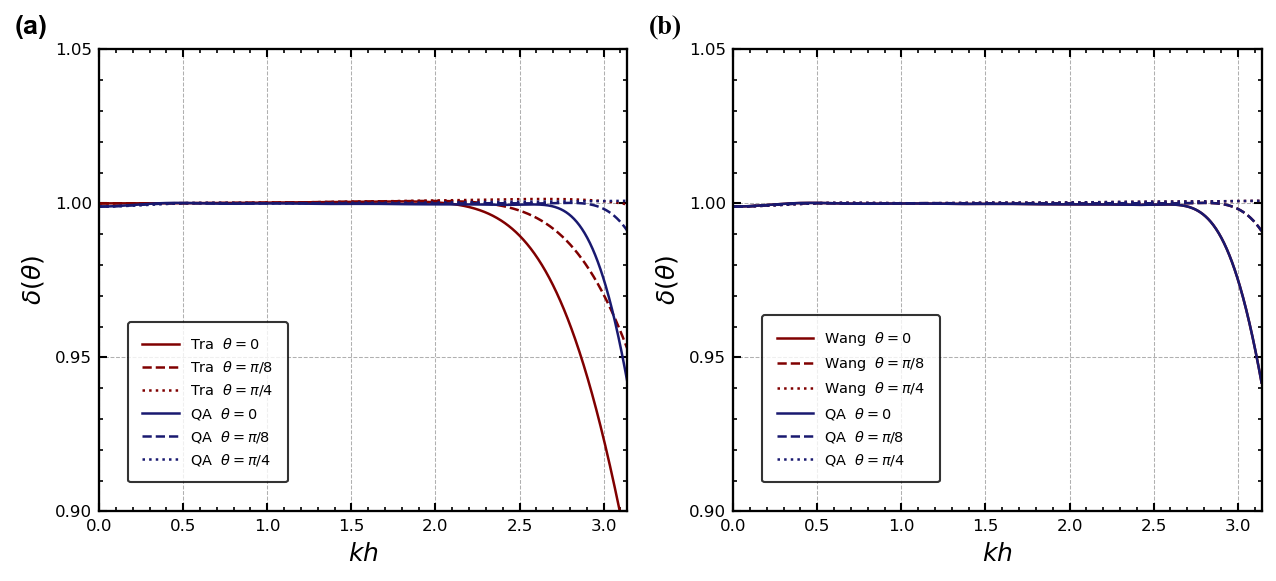

In [36]:
fig, ax = show_disp_curve(result_dict)
# fig.savefig("2D_low_velocity_reuslt.png", dpi=300)
# fig.savefig("2D_low_velocity_reuslt.pdf", dpi=600, format="pdf")

## high speed

In [37]:
v = 4500
h = 20
tao = 0.001
freq_max_set = [90]
M_set = [10]
max_iter_num = 20
tra_a0_dict = solve_coeff_Taylor()
wang_a0_dict, linear_sys = solve_coeff_Wang()
qa_a0_dict = solve_coeff_QA()
result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))

solve_coeff_Taylor Time Consuming: 0.000334 s
Current object function value is 0.9372177106833968


~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.24402812e+00 -1.21681592e-01  3.81045674e-02 -1.57874590e-02
   7.17431282e-03 -3.29799638e-03  1.45263560e-03 -5.82563235e-04
   1.95036308e-04 -4.76762588e-05]]
Current object function value is 1.9459504200553092e-05


~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.24404302e+00 -1.21722149e-01  3.81583176e-02 -1.58287627e-02
   7.19516633e-03 -3.30425740e-03  1.45221618e-03 -5.80621338e-04
   1.93724974e-04 -4.71416740e-05]]
Current object function value is 2.2918937828053346e-08


~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.24404301e+00 -1.21722142e-01  3.81583124e-02 -1.58287582e-02
   7.19516236e-03 -3.30425403e-03  1.45221369e-03 -5.80619748e-04
   1.93724176e-04 -4.71413213e-05]]
Current object function value is 2.2918926075317675e-08


~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coef

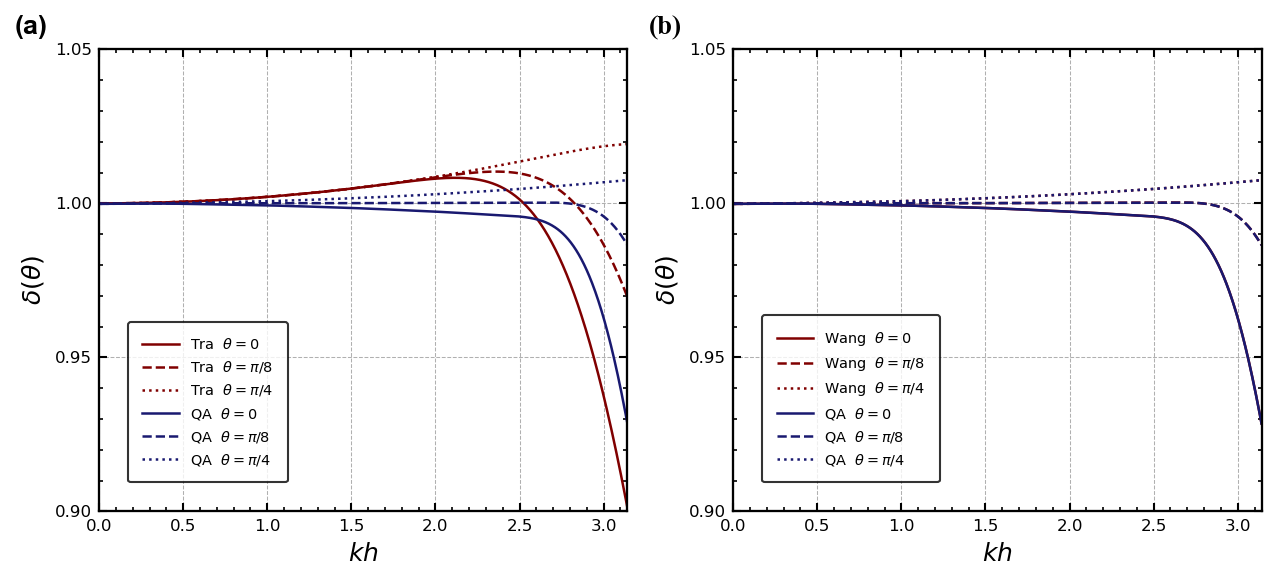

In [38]:
fig, ax = show_disp_curve(result_dict)
# fig.savefig("2D_high_velocity_reuslt.png", dpi=300)
# fig.savefig("2D_high_velocity_reuslt.pdf", dpi=600, format="pdf")